### Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
sns.set_style("whitegrid")

In [2]:
# Daftar file dari folder /Data/Twitter

parent_dir = "./Data/Twitter"
os.listdir(parent_dir)

['goto_count_202211091623.csv',
 'shopee_count_202211091616.csv',
 'tweets_twitter_202211071059.csv',
 'twitter.txt']

### Import Data

Tanggal pengerjaan: **9 November 2022** <br>

Data yang digunakan merupakan hasil ekstraksi data dari Twitter API mulai dari **7 hari sebelum tanggal pengerjaan** hingga **tanggal pengerjaan**. <br>

* Keterbatasan data tersebut terjadi karena pengguna memperoleh akses **"Essential"** daripada **"Elevated"** dan **"Academic Research"**

In [3]:
shopee_csv = os.path.join(parent_dir, 'shopee_count_202211091616.csv')
goto_csv = os.path.join(parent_dir, 'goto_count_202211091623.csv')

shopee_tweets = pd.read_csv(shopee_csv)
goto_tweets = pd.read_csv(goto_csv)

### Memeriksa Tipe Data

In [4]:
shopee_tweets.info() # or goto_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   start        169 non-null    object
 1   end          169 non-null    object
 2   tweet_count  169 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.1+ KB


In [5]:
shopee_tweets.head() # or goto_tweets.head()

,start,end,tweet_count
0,2022-11-02T09:15:16.000Z,2022-11-02T10:00:00.000Z,24
1,2022-11-02T10:00:00.000Z,2022-11-02T11:00:00.000Z,23
2,2022-11-02T11:00:00.000Z,2022-11-02T12:00:00.000Z,70
3,2022-11-02T12:00:00.000Z,2022-11-02T13:00:00.000Z,75
4,2022-11-02T13:00:00.000Z,2022-11-02T14:00:00.000Z,101


### Data Cleaning

In [6]:
# Memilih kolom "start" dan "tweet_count"
shopee_tweets = shopee_tweets.iloc[:,[0,-1]]
goto_tweets = goto_tweets.iloc[:,[0,-1]]

In [7]:
# Mengganti nilai pada baris pertama dan kolom "start" agar menjadi bulat
shopee_tweets = shopee_tweets.replace("2022-11-02T09:15:16.000Z", "2022-11-02T09:00:00.000Z")
goto_tweets = goto_tweets.replace("2022-11-02T09:21:50.000Z", "2022-11-02T09:00:00.000Z")

In [8]:
# Mengubah kolom start yang sebelum bertipe data string menjadi datetime
shopee_tweets["start"] = pd.to_datetime(shopee_tweets["start"], format="%Y-%m-%dT%H:%M:%S.000Z")
goto_tweets["start"] = pd.to_datetime(goto_tweets["start"], format="%Y-%m-%dT%H:%M:%S.000Z")

In [9]:
# Melihat bentuk data setelah dibersihkan
shopee_tweets.head() # goto_tweets.head()

,start,tweet_count
0,2022-11-02 09:00:00,24
1,2022-11-02 10:00:00,23
2,2022-11-02 11:00:00,70
3,2022-11-02 12:00:00,75
4,2022-11-02 13:00:00,101


In [10]:
# Melihat tipe data dari dataset setelah dibersihkan
shopee_tweets.info() #goto_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   start        169 non-null    datetime64[ns]
 1   tweet_count  169 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


### Plotting the Data into Graph

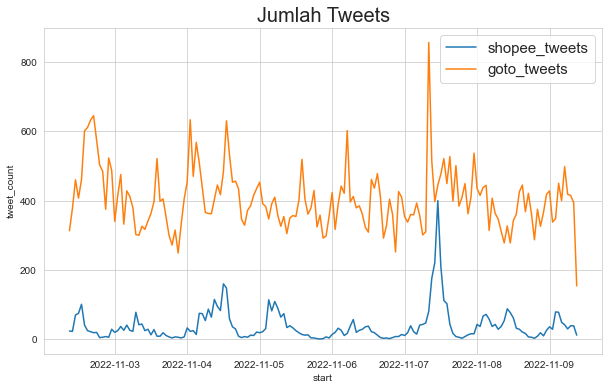

In [11]:
# Menggambar grafik tweet count selama 7 hari terakhir
plt.figure(figsize=(10,6))
sns.lineplot(data=shopee_tweets, x="start", y="tweet_count", legend="brief", label="shopee_tweets")
sns.lineplot(data=goto_tweets, x="start", y="tweet_count", legend="brief", label="goto_tweets")
plt.title("Jumlah Tweets", fontsize=20)
plt.legend(prop={'size': 15})
plt.show()

**Kesimpulan:**<br>
Dapat dilihat bahwa **tweet count Shopee lebih rendah daripada GoTo untuk setiap harinya**, meskipun Shopee sedang gencar-gencarnya melakukan iklan Harbolnas secara besar-besaran per bulannya. Seperti layaknya Shopee, GoTo juga merupakan penggabungan antara GoJek dan Tokopedia sehingga GoTo dan Shopee memiliki peran yang sama secara digital.<br><br>

Selanjutnya akan ditelusuri lebih lanjut mengenai **prediksi tweet count Shopee** menggunakan Deep Learning.

In [12]:
data = shopee_tweets.copy()
data.rename(columns = {'start': 'date', 'tweet_count':'shopee_tweets'}, inplace = True)
data["goto_tweets"] = goto_tweets["tweet_count"]
data.to_csv("shopee_goto_tweets.csv")

### Split the Dataset

In [13]:
print("Jumlah data tweet count Shopee:", len(shopee_tweets))

Jumlah data tweet count Shopee: 169


In [14]:
# Mendefinisikan variabel
time = [i for i in range(len(shopee_tweets))]
tweet_count = list(shopee_tweets["tweet_count"])

# Konversi time dan tweet_count ke numpy array
time = np.array(time)
series = np.array(tweet_count)

In [15]:
# Membagi dataset menjadi training dan validation data
split_time = 100

# Training data
time_train = time[:split_time]
x_train = series[:split_time]

# Validation data
time_valid = time[split_time:]
x_valid = series[split_time:]

### Prepare Features and Label

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [25]:
window_size = 5
batch_size = 4
shuffle_buffer = 10

# Menghasilkan dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [18]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                180       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.RMSprop(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
24/24 [==============================] - 2s 58ms/step - loss: 21.6192 - lr: 1.0000e-08
Epoch 2/100
24/24 [==============================] - 0s 949us/step - loss: 21.6184 - lr: 1.1220e-08
Epoch 3/100
24/24 [==============================] - 0s 853us/step - loss: 21.6176 - lr: 1.2589e-08
Epoch 4/100
24/24 [==============================] - 0s 886us/step - loss: 21.6167 - lr: 1.4125e-08
Epoch 5/100
24/24 [==============================] - 0s 945us/step - loss: 21.6158 - lr: 1.5849e-08
Epoch 6/100
24/24 [==============================] - 0s 998us/step - loss: 21.6147 - lr: 1.7783e-08
Epoch 7/100
24/24 [==============================] - 0s 864us/step - loss: 21.6133 - lr: 1.9953e-08
Epoch 8/100
24/24 [==============================] - 0s 868us/step - loss: 21.6118 - lr: 2.2387e-08
Epoch 9/100
24/24 [==============================] - 0s 864us/step - loss: 21.6102 - lr: 2.5119e-08
Epoch 10/100
24/24 [==============================] - 0s 835us/step - loss: 21.6084 - lr: 2.8184e-08


(1e-08, 0.001, 0.0, 100.0)

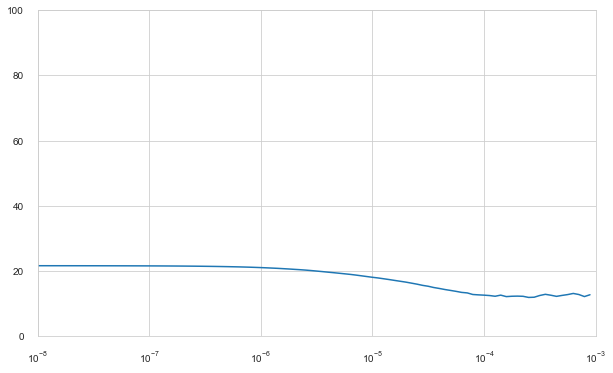

In [20]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [21]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=300)

Epoch 1/300
24/24 [==============================] - 1s 1ms/step - loss: 12.7159 - mae: 13.1983
Epoch 2/300
24/24 [==============================] - 0s 889us/step - loss: 12.4563 - mae: 12.9426
Epoch 3/300
24/24 [==============================] - 0s 860us/step - loss: 12.2312 - mae: 12.7194
Epoch 4/300
24/24 [==============================] - 0s 909us/step - loss: 12.0307 - mae: 12.5144
Epoch 5/300
24/24 [==============================] - 0s 929us/step - loss: 11.8910 - mae: 12.3772
Epoch 6/300
24/24 [==============================] - 0s 957us/step - loss: 11.7577 - mae: 12.2351
Epoch 7/300
24/24 [==============================] - 0s 906us/step - loss: 11.6379 - mae: 12.1182
Epoch 8/300
24/24 [==============================] - 0s 911us/step - loss: 11.5510 - mae: 12.0337
Epoch 9/300
24/24 [==============================] - 0s 877us/step - loss: 11.4210 - mae: 11.9075
Epoch 10/300
24/24 [==============================] - 0s 886us/step - loss: 11.3466 - mae: 11.8270
Epoch 11/300
24/24 [=

24/24 [==============================] - 0s 925us/step - loss: 10.4332 - mae: 10.9006
Epoch 85/300
24/24 [==============================] - 0s 950us/step - loss: 10.4099 - mae: 10.8766
Epoch 86/300
24/24 [==============================] - 0s 895us/step - loss: 10.4079 - mae: 10.8743
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 10.4197 - mae: 10.8885
Epoch 88/300
24/24 [==============================] - 0s 984us/step - loss: 10.4061 - mae: 10.8727
Epoch 89/300
24/24 [==============================] - 0s 917us/step - loss: 10.3992 - mae: 10.8659
Epoch 90/300
24/24 [==============================] - 0s 1ms/step - loss: 10.3874 - mae: 10.8532
Epoch 91/300
24/24 [==============================] - 0s 970us/step - loss: 10.3910 - mae: 10.8571
Epoch 92/300
24/24 [==============================] - 0s 910us/step - loss: 10.3945 - mae: 10.8632
Epoch 93/300
24/24 [==============================] - 0s 963us/step - loss: 10.3810 - mae: 10.8467
Epoch 94/300
24/24 [=======

24/24 [==============================] - 0s 884us/step - loss: 9.9153 - mae: 10.3730
Epoch 249/300
24/24 [==============================] - 0s 893us/step - loss: 9.9201 - mae: 10.3762
Epoch 250/300
24/24 [==============================] - 0s 862us/step - loss: 9.9034 - mae: 10.3637
Epoch 251/300
24/24 [==============================] - 0s 945us/step - loss: 9.9005 - mae: 10.3594
Epoch 252/300
24/24 [==============================] - 0s 925us/step - loss: 9.9001 - mae: 10.3574
Epoch 253/300
24/24 [==============================] - 0s 899us/step - loss: 9.9024 - mae: 10.3585
Epoch 254/300
24/24 [==============================] - 0s 902us/step - loss: 9.8877 - mae: 10.3455
Epoch 255/300
24/24 [==============================] - 0s 996us/step - loss: 9.8980 - mae: 10.3618
Epoch 256/300
24/24 [==============================] - 0s 1ms/step - loss: 9.8837 - mae: 10.3399
Epoch 257/300
24/24 [==============================] - 0s 987us/step - loss: 9.8835 - mae: 10.3400
Epoch 258/300
24/24 [=====

### Save the Model

In [22]:
# export_h5 = 'saved_model/shopee-tweets.h5'
# model.save(export_h5)

# print("Model saved!")

### Model Prediction

In [26]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

### Test the Saved Model

73
18/18 [==============================] - 0s 3ms/step
69
69


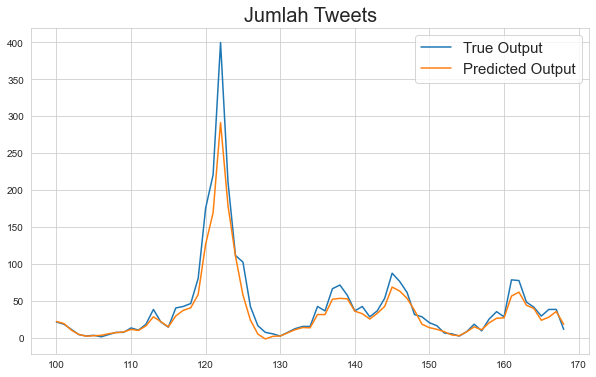

In [54]:
from tensorflow.keras.models import load_model

model = load_model("saved_model/shopee-tweets.h5")

# Reduce the original series
forecast_series = series[split_time-window_size+1:]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.figure(figsize=(10,6))
sns.lineplot(x=time_valid, y=x_valid, legend="brief", label="True Output")
sns.lineplot(x=time_valid, y=results, legend="brief", label="Predicted Output")
plt.title("Jumlah Tweets", fontsize=20)
plt.legend(prop={'size': 15})
plt.show()

In [55]:
# Menghitung Mean Absolute Error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.275803

42/42 [==============================] - 0s 2ms/step


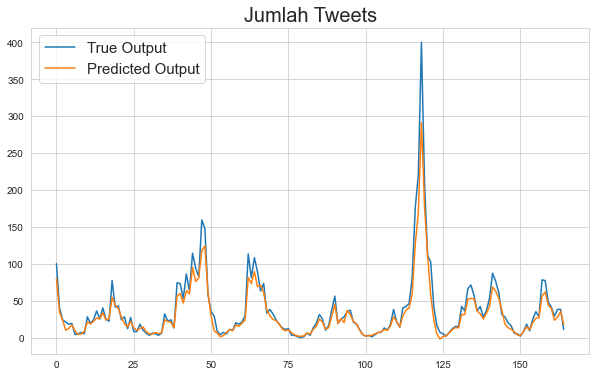

In [56]:
from tensorflow.keras.models import load_model

model = load_model("saved_model/shopee-tweets.h5")

# Original series
forecast_series = series

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.figure(figsize=(10,6))
sns.lineplot(x=time[:-batch_size], y=series[batch_size:], legend="brief", label="True Output")
sns.lineplot(x=time[:-batch_size], y=results, legend="brief", label="Predicted Output")
plt.title("Jumlah Tweets", fontsize=20)
plt.legend(prop={'size': 15})
plt.show()

In [57]:
# Define variables for forecast
forecast_time = time_valid
forecast_val = results[-len(forecast_time):]

In [58]:
print(f"forecast_time: {len(forecast_time)}")
print(f"forecast_val: {len(forecast_val)}")

forecast_time: 69
forecast_val: 69


In [59]:
hours = 24
days = 21
idx = time_valid[-1]

for _ in range(days*hours):
    
    # Append index
    idx += 1
    forecast_time = np.append(forecast_time, idx)
    
    # Reduce the original series
    forecast_series = forecast_val[-window_size:]

    # Use helper function to generate predictions
    forecast = model_forecast(model, forecast_series, window_size, batch_size)

    # Drop single dimensional axis
    prediction = forecast.squeeze()
    
    # Append the prediction
    forecast_val = np.append(forecast_val, prediction)

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step
573
573


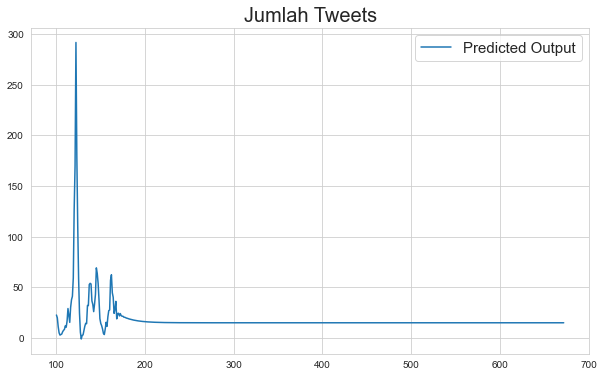

In [60]:
# Plot the results
plt.figure(figsize=(10,6))
sns.lineplot(x=forecast_time, y=forecast_val, legend="brief", label="Predicted Output")
plt.title("Jumlah Tweets", fontsize=20)
plt.legend(prop={'size': 15})
plt.show()

### Save the Predicted Data

In [74]:
from datetime import datetime  
from datetime import timedelta 

forecast_dates = []
for idx in range(len(forecast_time)):
    if idx == 0:
        forecast_dates.append(shopee_tweet_counts.iloc[split_time-window_size]["Time"])
    else:
        temp_date = forecast_dates[-1]
        temp_date = temp_date + timedelta(hours=1)
        forecast_dates.append(temp_date)

for date in forecast_dates:
    print(date)

2022-11-06 12:00:00
2022-11-06 13:00:00
2022-11-06 14:00:00
2022-11-06 15:00:00
2022-11-06 16:00:00
2022-11-06 17:00:00
2022-11-06 18:00:00
2022-11-06 19:00:00
2022-11-06 20:00:00
2022-11-06 21:00:00
2022-11-06 22:00:00
2022-11-06 23:00:00
2022-11-07 00:00:00
2022-11-07 01:00:00
2022-11-07 02:00:00
2022-11-07 03:00:00
2022-11-07 04:00:00
2022-11-07 05:00:00
2022-11-07 06:00:00
2022-11-07 07:00:00
2022-11-07 08:00:00
2022-11-07 09:00:00
2022-11-07 10:00:00
2022-11-07 11:00:00
2022-11-07 12:00:00
2022-11-07 13:00:00
2022-11-07 14:00:00
2022-11-07 15:00:00
2022-11-07 16:00:00
2022-11-07 17:00:00
2022-11-07 18:00:00
2022-11-07 19:00:00
2022-11-07 20:00:00
2022-11-07 21:00:00
2022-11-07 22:00:00
2022-11-07 23:00:00
2022-11-08 00:00:00
2022-11-08 01:00:00
2022-11-08 02:00:00
2022-11-08 03:00:00
2022-11-08 04:00:00
2022-11-08 05:00:00
2022-11-08 06:00:00
2022-11-08 07:00:00
2022-11-08 08:00:00
2022-11-08 09:00:00
2022-11-08 10:00:00
2022-11-08 11:00:00
2022-11-08 12:00:00
2022-11-08 13:00:00


In [75]:
data = {"Time": forecast_dates, "Predicted Output": forecast_val}
shopee_predicted = pd.DataFrame(data).reset_index(drop=True)
shopee_predicted.tail()

,Time,Predicted Output
568,2022-11-30 04:00:00,15.033879
569,2022-11-30 05:00:00,15.033879
570,2022-11-30 06:00:00,15.033879
571,2022-11-30 07:00:00,15.033879
572,2022-11-30 08:00:00,15.033879


In [76]:
shopee_predicted.to_csv(os.path.join("Output", "shopee_predicted.csv"))